# dot calculation

By utilizing the structure of the Amat, we can compute the vector matrix product in a more efficient way.

In this notebook, we will check the faster way actually works and compare the performance with the naive way.


In [1]:
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from exputils.Amat.get import get_Amat
from exputils.dot.calc_dot import calc_dot
from exputils.dot.get_topK_Amat import get_topK_Amat
from exputils.stabilizer_group import total_stabilizer_group_size
from exputils.state.random_ket import make_random_quantum_state

In [2]:
from exputils.math.q_binom import q_binomial


n = 10
total = 0
for k in range(10 + 1):
    if k == 0:
        term = 1 << k
    else:
        term = q_binomial(n, k) * (1 << (n + k * (k + 1) // 2))
    total += term
    print(f"{k:>2}, {term:>20}, {total:>20}")

 0,                    1,                    1
 1,              2095104,              2095105
 2,           1427464192,           1429559297
 3,         416003850240,         417433409537
 4,       56354654912512,       56772088322049
 5,     3664870461407232,     3721642549729281
 6,   115414333260824576,   119135975810553857
 7,  1744846613077032960,  1863982588887586817
 8, 12261824041702129664, 14125806630589716481
 9, 36857459350400139264, 50983265980989855745
10, 36893488147419103232, 87876754128408958977


n=3
331: "max", values[0].first = max,0.7187691618
[k|progress|range]: 1 | 1.20000e+02/1.08000e+03 | [0.01721, 0.87813] | 2[ms]
[k|progress|range]: 2 | 5.68000e+02/1.08000e+03 | [0.01721, 0.87813] | 3[ms]
[k|progress|range]: 3 | 1.08000e+03/1.08000e+03 | [0.01721, 0.87813] | 3[ms]
 calculation time : 3[ms]
branch cut / total: 0/1080
t1-t0=0.00047400000039488077
t2-t1=0.9107563000288792
t3-t2=0.19100049999542534
Counter({8: 832, 4: 448, 2: 112, 1: 8})


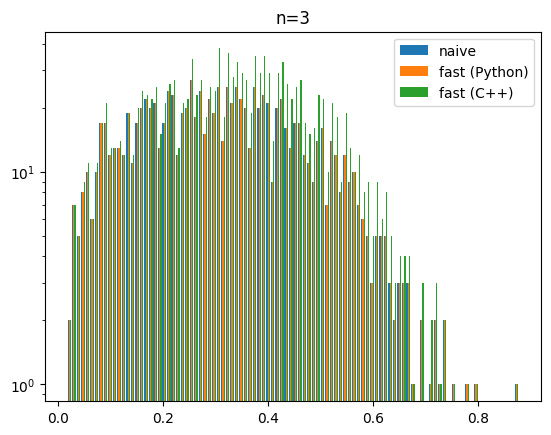

n=4
331: "max", values[0].first = max,0.6925513034
[k|progress|range]: 1 | 4.96000e+02/3.67200e+04 | [0.00646, 0.69255] | 2[ms]
[k|progress|range]: 2 | 4.97600e+03/3.67200e+04 | [0.06560, 0.69255] | 3[ms]
[k|progress|range]: 3 | 2.03360e+04/3.67200e+04 | [0.30193, 0.69257] | 5[ms]
[k|progress|range]: 4 | 3.67200e+04/3.67200e+04 | [0.35475, 0.69257] | 7[ms]
 calculation time : 7[ms]
branch cut / total: 0/36720
t1-t0=0.0009302999824285507
t2-t1=0.07770070002879947
t3-t2=0.23012050002580509
Counter({16: 2276, 8: 2057, 4: 597, 2: 68, 1: 2})


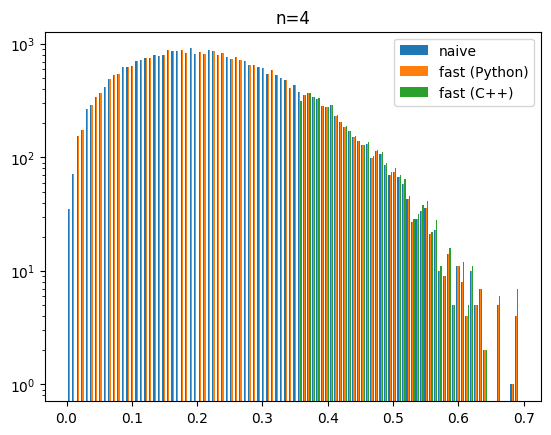

n=5
331: "max", values[0].first = max,0.5991223975
[k|progress|range]: 1 | 2.01600e+03/2.42352e+06 | [0.00392, 0.59912] | 4[ms]
[k|progress|range]: 2 | 4.16960e+04/2.42352e+06 | [0.25815, 0.59912] | 20[ms]
[k|progress|range]: 3 | 3.59136e+05/2.42352e+06 | [0.35576, 0.59912] | 37[ms]
[k|progress|range]: 4 | 1.37494e+06/2.42352e+06 | [0.40590, 0.59912] | 52[ms]
[k|progress|range]: 5 | 2.42352e+06/2.42352e+06 | [0.42558, 0.59912] | 106[ms]
 calculation time : 106[ms]
branch cut / total: 540160/2423520
t1-t0=0.07050820003496483
t2-t1=4.249102799978573
t3-t2=0.3918707999982871
Counter({32: 2386, 16: 2056, 8: 529, 4: 29})


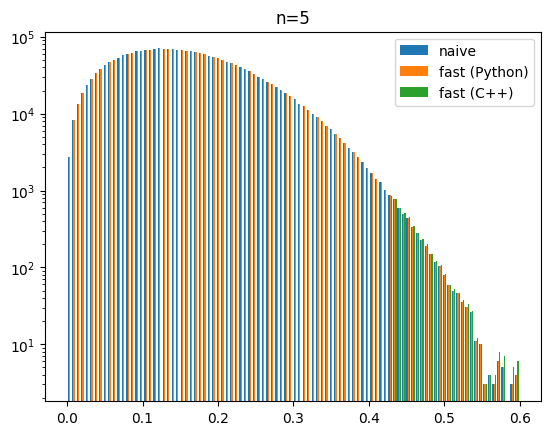

In [3]:
# g++ exputils/cpp/calc_dot.cpp -o exputils/cpp/calc_dot.exe -std=c++17 -O2 -mtune=native -march=native -fopenmp -lz

for n in [3, 4, 5]:
    print(f"{n=}")

    random.seed(0)
    psi = make_random_quantum_state("pure", n, seed=0)

    Amat = get_Amat(n)
    t0 = time.perf_counter()
    ansSlow = np.array(psi).conj() @ Amat
    t1 = time.perf_counter()
    ansFast = calc_dot(n, psi.tolist())
    t2 = time.perf_counter()
    states = get_topK_Amat(n, psi, is_dual_mode=False)
    ansFast2 = np.abs(psi.conjugate() @ states)
    t3 = time.perf_counter()
    print(f"{t1-t0=}")
    print(f"{t2-t1=}")
    print(f"{t3-t2=}")
    print(Counter(np.count_nonzero(states.toarray(), axis=0)))

    plt.hist([np.abs(ansSlow), np.abs(ansFast), np.abs(ansFast2)], bins=100)
    plt.title(f"n={n}")
    plt.legend(["naive", "fast (Python)", "fast (C++)"])
    plt.yscale("log")
    plt.show()

    assert len(ansSlow) == len(ansFast)
    assert np.allclose(np.sort(ansSlow), np.sort(ansFast))
    # if n <= 4:
    #     assert np.allclose(np.sort(np.abs(ansSlow)), np.sort(np.abs(ansFast2)))

    # if n <= 2:
    #     mat = np.zeros((2, len(ansSlow)), dtype=np.complex128)
    #     for i in range(len(ansSlow)):
    #         mat[0, i] = ansSlow[i]
    #         mat[1, i] = ansFast[i]
    #     vis_matrix(mat)

    # assert np.allclose(np.sort(ansSlow), np.sort(ansFast))

    # cnt = 3 if n == 1 else 30
    # col_idxs = np.argpartition(np.abs(ansFast), -cnt)[-cnt:]
    # dots_abs_ans = np.abs(ansFast[col_idxs])
    # dots_abs_check = []
    # states = recovery_states_from_idxs(n, col_idxs)
    # for state in states:
    #     dots_abs_check.append(abs(state @ psi))
    # dots_abs_check = np.array(dots_abs_check)
    # print(f"{dots_abs_ans=}")
    # print(f"{dots_abs_check=}")
    # assert np.allclose(np.sort(dots_abs_ans), np.sort(dots_abs_check))

n=6 total_stabilizer_group_size(n)=315057600
psi[:10]=array([ 0.00191592-0.055118j  ,  0.05823157+0.03303339j,
       -0.0873583 -0.00839837j, -0.042261  -0.06658054j,
       -0.04508918-0.03069197j, -0.05638643-0.08410659j,
        0.0249202 +0.0817603j , -0.03569263-0.11142187j,
        0.14494395-0.06691227j, -0.09171176+0.03051833j])
331: "max", values[0].first = max,0.4976276262
[k|progress|range]: 1 | 8.12800e+03/3.15058e+08 | [0.08844, 0.49763] | 8[ms]
[k|progress|range]: 2 | 3.41440e+05/3.15058e+08 | [0.26120, 0.49763] | 56[ms]
[k|progress|range]: 3 | 6.05536e+06/3.15058e+08 | [0.33284, 0.49763] | 138[ms]
[k|progress|range]: 4 | 4.87193e+07/3.15058e+08 | [0.37251, 0.49763] | 233[ms]
[k|progress|range]: 5 | 1.80840e+08/3.15058e+08 | [0.39373, 0.53119] | 393[ms]
[k|progress|range]: 6 | 3.15058e+08/3.15058e+08 | [0.40177, 0.53119] | 978[ms]
 calculation time : 978[ms]
branch cut / total: 279816704/315057600
t1-t0=1.6083113999920897
Counter({32: 2105, 64: 1896, 16: 830, 8: 157, 4: 

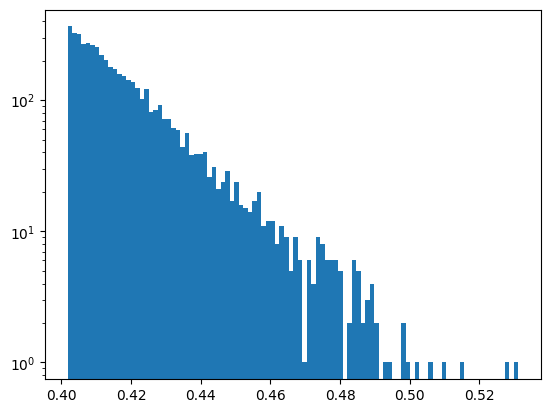

n=7 total_stabilizer_group_size(n)=81284860800
psi[:10]=array([ 0.07913827+0.06814959j,  0.00593093+0.01811256j,
        0.05109879-0.00323261j,  0.02199331-0.00808749j,
       -0.08410508-0.00334621j,  0.05044391-0.01531157j,
       -0.05669442+0.08172552j, -0.01057939-0.05585817j,
        0.14989151-0.01841798j, -0.10853592+0.06166335j])
331: "max", values[0].first = max,0.3980672890
[k|progress|range]: 1 | 3.26400e+04/8.12849e+10 | [0.12212, 0.39807] | 12[ms]
[k|progress|range]: 2 | 2.76365e+06/8.12849e+10 | [0.22308, 0.39807] | 114[ms]
[k|progress|range]: 3 | 9.95194e+07/8.12849e+10 | [0.27590, 0.39807] | 404[ms]
[k|progress|range]: 4 | 1.64761e+09/8.12849e+10 | [0.31027, 0.41110] | 1127[ms]
[k|progress|range]: 5 | 1.28338e+10/8.12849e+10 | [0.33296, 0.41110] | 2806[ms]
[k|progress|range]: 6 | 4.69251e+10/8.12849e+10 | [0.34634, 0.41908] | 5696[ms]
[k|progress|range]: 7 | 8.12849e+10/8.12849e+10 | [0.35172, 0.41908] | 7904[ms]
 calculation time : 7904[ms]
branch cut / total: 810072

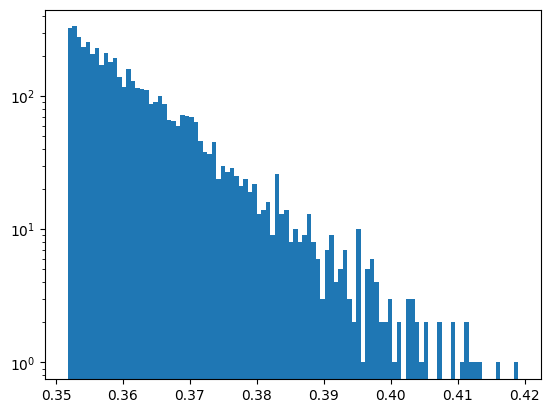

n=8 total_stabilizer_group_size(n)=41780418451200
psi[:10]=array([-0.02468419-0.01300555j, -0.04743796-0.01841991j,
       -0.04517999+0.00046806j, -0.03190195-0.05473635j,
        0.03236416-0.00138037j,  0.00424968-0.07011695j,
        0.0580995 -0.01847172j,  0.07891767-0.06241548j,
        0.08388194+0.01988365j,  0.03656884+0.02063767j])
331: "max", values[0].first = max,0.3053693103
[k|progress|range]: 1 | 1.30816e+05/4.17804e+13 | [0.11717, 0.30537] | 38[ms]
[k|progress|range]: 2 | 2.22390e+07/4.17804e+13 | [0.18714, 0.30537] | 365[ms]
[k|progress|range]: 3 | 1.61403e+09/4.17804e+13 | [0.22724, 0.30537] | 1813[ms]


KeyboardInterrupt: 

In [4]:
for n in [6, 7, 8]:
    print(f"{n=} {total_stabilizer_group_size(n)=}")

    random.seed(0)
    psi = make_random_quantum_state("pure", n, seed=0)
    print(f"{psi[:10]=}")

    t0 = time.perf_counter()
    states = get_topK_Amat(n, psi, is_dual_mode=False)
    ans = np.abs(psi.conj().T @ states)
    t1 = time.perf_counter()
    print(f"{t1-t0=}")
    print(Counter(np.count_nonzero(states.toarray(), axis=0)))

    if n <= 5:
        ansSlow = np.abs(calc_dot(n, psi.tolist()))
        plt.hist([ans, ansSlow], bins=100)
    else:
        plt.hist(ans, bins=100)
    plt.yscale("log")
    plt.show()